In [1]:
import os
import json
import time
import pandas as pd
from src.gender import gender
from src.vycisti import vycisti
df = pd.read_json(os.path.join("data", "filmy.json"))
with open(os.path.join("data_fixes", "opravy.json"), encoding="utf-8") as opravy:
    opravy = json.loads(opravy.read())
with open(os.path.join("data_fixes", "seznamy.json"), encoding="utf-8") as seznamy:
    seznamy = json.loads(seznamy.read())
with open(os.path.join("data_fixes", "zeny.json"), encoding="utf-8") as zeny:
    zeny = json.loads(zeny.read())
with open(os.path.join("data_fixes", "nelide.json"), encoding="utf-8") as nelide:
    nelide = json.loads(nelide.read())
df = vycisti(df, opravy)

2023/06/06 18:10:06 z 4555 řádků odstraněno 133. Aktuální dataframe má 4422 řádků.


## Dlouhý výpočet, kterým se nechceme zdržovat v sešitu věnovaném tvůrcům

In [2]:
profese = seznamy["profese"]
persony = pd.read_json(os.path.join("data", "persony.json"))
jmena_lidi = persony[persony["Osoba"] == "fyzická"]["Jméno"].to_list()

In [3]:
profese.remove("Účinkují")
profese.remove("Hudba, text a zpěv písně")
profese.remove("Hudba k písni")

In [4]:
def plose_jednoduse(x):
    seznam = []
    for y in x:
        if y == None:
            pass
        if isinstance(y, str):
            if y not in seznam:
                seznam.append(y)
        if isinstance(y, list):
            for z in y:
                if z not in seznam:
                    seznam.append(z)
    return(seznam)

In [5]:
def kolik_skoncilo(konce, jmena_lidi):
    st = time.time()
    konce["Lidé"] = konce[profese].values.tolist()
    konce["Lidé"] = konce["Lidé"].apply(lambda x: plose_jednoduse(x))
    konce = konce[["Copyright","Lidé","Film"]].explode("Lidé")
    konce = konce[konce["Lidé"].isin(jmena_lidi)]
    konce = konce.groupby("Copyright")["Lidé"].apply(lambda x: list(set(x)))
    konce = pd.DataFrame(konce).explode("Lidé")
    konce = konce.reset_index()  
    print(f"{len(konce)} člověkoletopočtů")
    konce["Příští film"] = konce[["Lidé","Copyright"]].apply(lambda x: konce[(konce["Lidé"] == x["Lidé"]) & (konce["Copyright"] > x["Copyright"])]["Copyright"].min(), axis = 1)
    konce = konce.rename(columns={"Lidé": "Jméno"})
    konce["Pauza"] = konce["Příští film"] - konce["Copyright"]
    print(f"čas výpočtu: {time.time() - st} s")
    return(konce)

In [6]:
konce = kolik_skoncilo(df, jmena_lidi)

95401 člověkoletopočtů
čas výpočtu: 1149.013797044754 s


In [7]:
konce.to_json(os.path.join("data", "pauzy.json"), orient="records")

In [8]:
konce.sample(5)

,Copyright,Jméno,Příští film,Pauza
91349,2019,Pavla Traxlerová (105033),NaN,NaN
85547,2015,Petr Vaněk (24908),2017.0,2.0
3539,1933,Antonín Soukup (87404),1934.0,1.0
93059,2020,Radka Malá (28394),NaN,NaN
1445,1926,Rosalie Chudobová (130037),NaN,NaN


## Explorace

<Axes: xlabel='Copyright'>

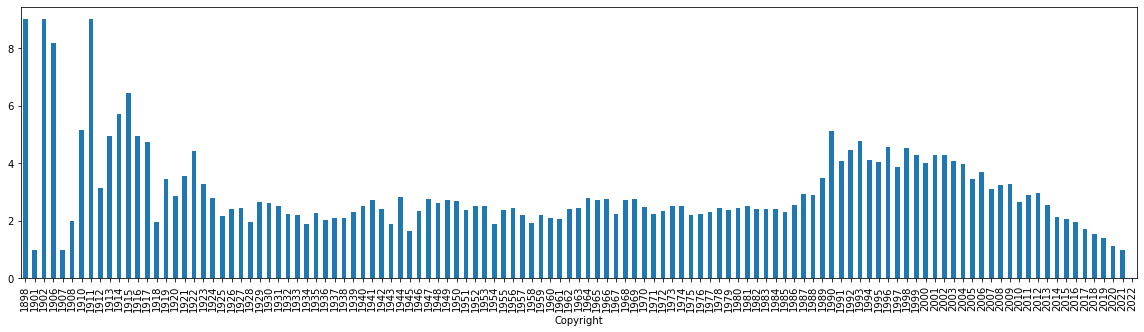

In [9]:
konce.groupby("Copyright")["Pauza"].mean().plot.bar(figsize=(20,5))

In [10]:
r3 = konce.groupby("Jméno")["Copyright"].nunique()
r3 = r3[r3 >= 5]
r3 = r3.index.to_list()

In [11]:
k3 = konce[konce["Jméno"].isin(r3)]

In [12]:
k3 = k3[k3["Copyright"].isin(range(1920,2011))]

In [13]:
k3 = k3.merge(persony[["Jméno","Rok úmrtí"]], on="Jméno")

In [14]:
k3["Příští film"] = pd.to_numeric(k3["Příští film"], errors="coerce")

In [15]:
k3["Rok úmrtí"] = pd.to_numeric(k3["Rok úmrtí"], errors="coerce")

In [16]:
k3.loc[k3["Příští film"] > k3["Rok úmrtí"],"Příští film"]=None

In [17]:
k3.groupby("Copyright")["Jméno"].nunique()

Copyright
1920    113
1921    138
1922    130
1923     81
1924     78
       ... 
2006    637
2007    545
2008    704
2009    817
2010    673
Name: Jméno, Length: 91, dtype: int64

In [18]:
k3.sample(5)

,Copyright,Jméno,Příští film,Pauza,Rok úmrtí
12951,1950,Růžena Rousová (40493),NaN,NaN,19.0
18218,1990,Václav Halama (21254),NaN,NaN,1975.0
17118,1964,Pavel Blumenfeld (7870),1966.0,2.0,1982.0
33604,1963,Miloš Macourek (1045),1965.0,2.0,2002.0
21800,1964,Josef Ouzký (126337),1966.0,2.0,1977.0


<Axes: xlabel='Copyright'>

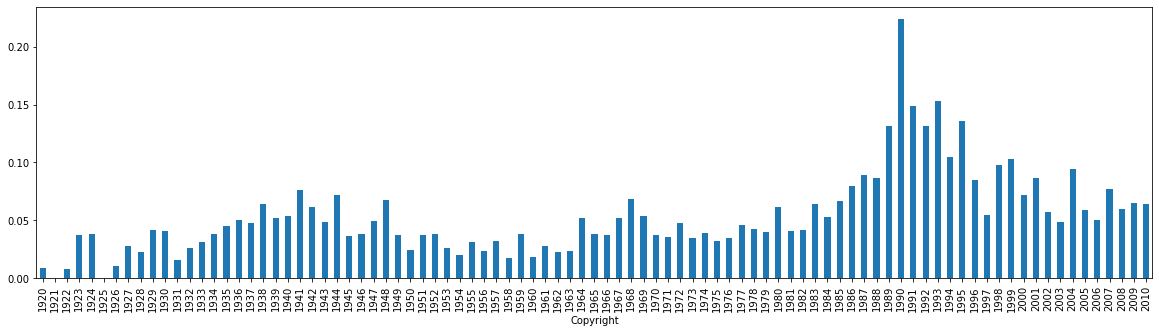

In [19]:
pd.Series(k3[k3["Pauza"].isnull()].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,5))

In [20]:
k3[k3["Copyright"] == 1992]

,Copyright,Jméno,Příští film,Pauza,Rok úmrtí
7691,1992,Svatopluk Beneš (13617),2003.0,11.0,2007.0
7903,1992,Nelly Gaierová (4888),1993.0,1.0,1995.0
9524,1992,Jiřina Bohdalová (2878),1993.0,1.0,NaN
10478,1992,Karel Černý (1241),2001.0,9.0,2014.0
10880,1992,Helena Růžičková (3862),1993.0,1.0,2004.0
...,...,...,...,...,...
52662,1992,Eva Malíková (20167),1993.0,1.0,NaN
52665,1992,Richard Řeřicha (2088),2000.0,8.0,NaN
52670,1992,Simona Peková (11310),1996.0,4.0,NaN
52679,1992,Josef Viewegh (29808),1996.0,4.0,NaN


<Axes: xlabel='Copyright'>

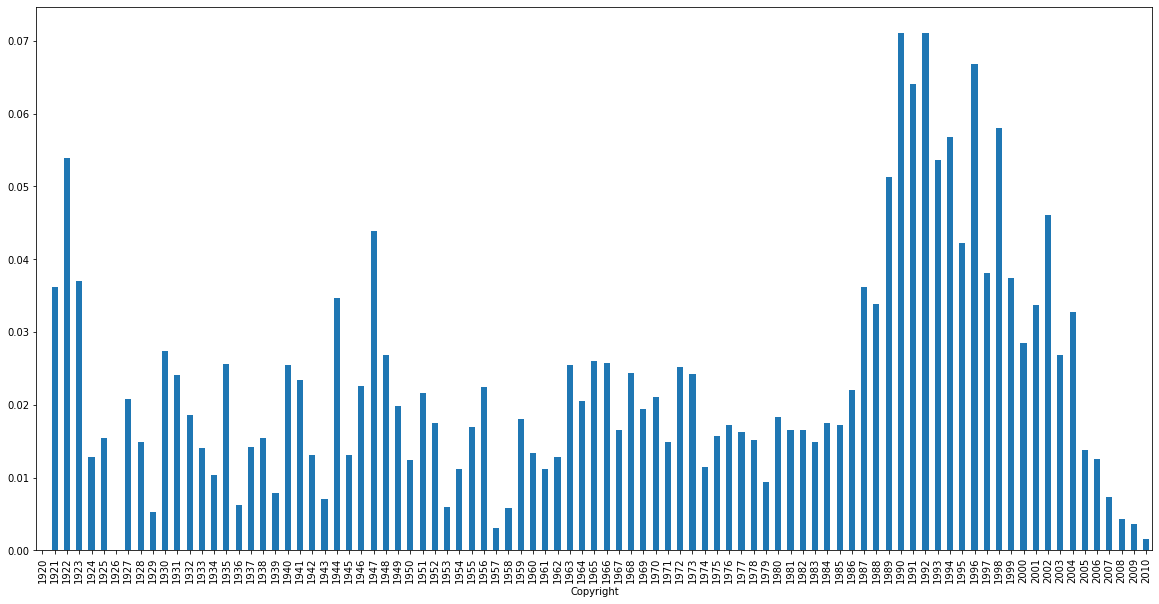

In [21]:
pd.Series(k3[(k3["Pauza"] >= 12)].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))

<Axes: xlabel='Copyright'>

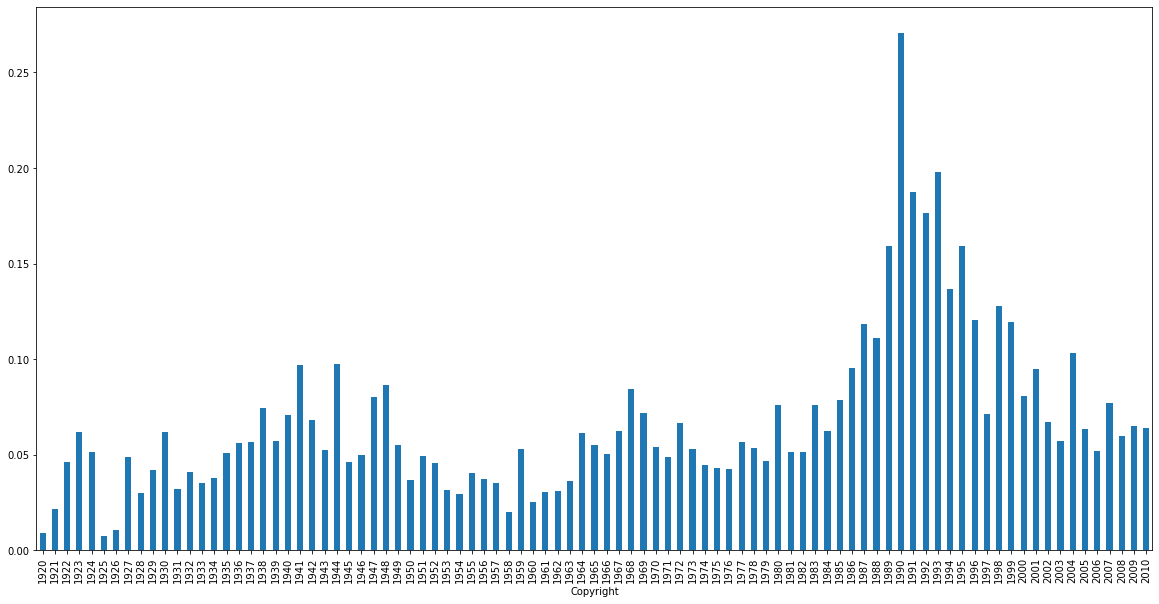

In [22]:
pd.Series(k3[(k3["Pauza"] >= 15) | (k3["Pauza"].isnull())].groupby("Copyright")["Jméno"].nunique() / k3.groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))

<Axes: xlabel='Copyright'>

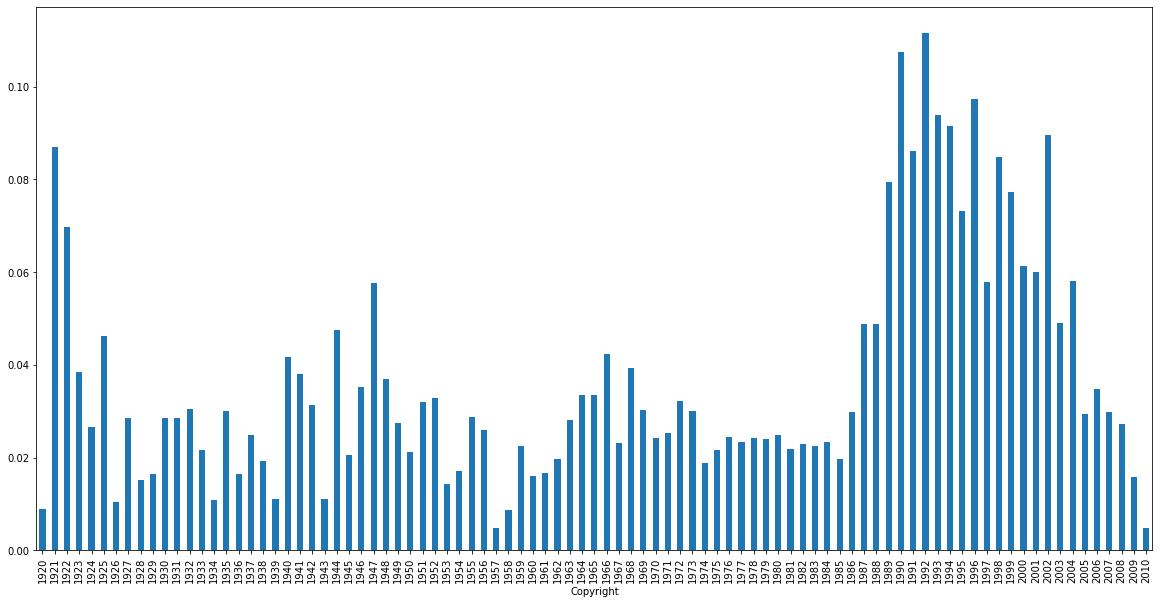

In [23]:
pd.Series(k3[(k3["Pauza"] >= 10)].groupby("Copyright")["Jméno"].nunique() / k3[~k3["Pauza"].isnull()].groupby("Copyright")["Jméno"].nunique()).plot.bar(figsize=(20,10))